# Using Neural Machine Translation with Attention in PyTorch for Question Generation
This notebook uses neural machine translation (with attention) in Pytorch to perform question generation. There are many improvements that can be made to improve the model and provide better results.

## Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import re
import time
import numpy as np
import unicodedata
import pandas as pd

from sklearn.model_selection import train_test_split

## Import Data from Google Drive
The SQUAD dataset was used for training the model. Some modifications were made to the SQUAD dataset to obtain a dataset in the format needed for Question Generation. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
data = pd.read_csv('/gdrive/My Drive/Jobs + Startup/Tangible AI/Question Generation - Tangible AI/Datasets/dataOnetoOneRemoveDuplicatesRougeN03.csv')
# data = pd.read_csv('/gdrive/My Drive/Jobs + Startup/Tangible AI/Question Generation - Tangible AI/Datasets/dataOnetoOneRemoveDuplicates.csv')

# If reducing dataset by topics

In [ ]:
data['Title'].unique()

array(['Beyoncé', 'Frédéric_Chopin',
       'Sino-Tibetan_relations_during_the_Ming_dynasty', 'IPod',
       'The_Legend_of_Zelda:_Twilight_Princess', 'Spectre_(2015_film)',
       '2008_Sichuan_earthquake', 'New_York_City',
       'To_Kill_a_Mockingbird', 'Solar_energy', 'Kanye_West', 'Buddhism',
       'American_Idol', 'Dog', '2008_Summer_Olympics_torch_relay',
       'Genome', 'Comprehensive_school', 'Republic_of_the_Congo',
       'Prime_minister', 'Institute_of_technology', 'Wayback_Machine',
       'Dutch_Republic', 'Symbiosis', 'Canadian_Armed_Forces',
       'Cardinal_(Catholicism)', 'Iranian_languages', 'Lighting',
       'Separation_of_powers_under_the_United_States_Constitution',
       'Architecture', 'Human_Development_Index', 'Southern_Europe',
       'BBC_Television', 'Arnold_Schwarzenegger', 'Plymouth', 'Heresy',
       'Warsaw_Pact', 'Materialism', 'Christian',
       'Sony_Music_Entertainment', 'Oklahoma_City', 'Hunter-gatherer',
       'United_Nations_Population_Fund

In [ ]:
titles = data['Title'].unique()
print(len(titles))

475


In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
nlp_lg = spacy.load('en_core_web_lg')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import spacy
chosenTitles = []
count = 0
nlp = spacy.load("en_core_web_sm")
for i in titles:
    doc = nlp_lg(i.replace('_', ' '))

    for ent in doc.ents:
        count += 1
        print(ent.label_, '     ', ent.text, ent.start_char, ent.end_char)

        if ent.label_ == 'PERSON':
            chosenTitles.append(i)
print(count)
print(len(chosenTitles))

PERSON       Frédéric Chopin 0 15
NORP       Sino-Tibetan 0 12
DATE       the Ming dynasty 30 46
ORG       IPod 0 4
WORK_OF_ART       The Legend of Zelda: 0 20
PERSON       Twilight Princess 21 38
PERSON       Spectre 0 7
DATE       2015 9 13
DATE       2008 0 4
GPE       Sichuan 5 12
GPE       New York City 0 13
PERSON       Kanye West 0 10
NORP       American 0 8
DATE       2008 Summer 0 11
EVENT       Olympics 12 20
GPE       Congo 16 21
ORG       Institute of technology 0 23
GPE       Dutch Republic 0 14
ORG       Canadian Armed Forces 0 21
NORP       Iranian 0 7
GPE       the United States Constitution 27 57
LOC       Southern Europe 0 15
ORG       BBC Television 0 14
PERSON       Arnold Schwarzenegger 0 21
GPE       Plymouth 0 8
ORG       Warsaw Pact 0 11
NORP       Christian 0 9
ORG       Sony Music Entertainment 0 24
GPE       Oklahoma City 0 13
PERSON       Hunter 0 6
ORG       United Nations Population Fund 0 30
GPE       Russian Soviet 0 14
GPE       Federative Socialist Rep

In [ ]:
data = data[data['Title'].isin(chosenTitles)]
data.describe()

Unnamed: 0  Unnamed: 0.1  ...         QAId  SentenceStart
count   2389.000000   2389.000000  ...  2389.000000    2389.000000
mean   22334.016325  26392.738803  ...     2.440352     123.605693
std    14134.015538  17222.703537  ...     2.562024      62.674161
min      354.000000    501.000000  ...     0.000000       0.000000
25%     9759.000000  11020.000000  ...     1.000000      81.000000
50%    21345.000000  24435.000000  ...     2.000000     112.000000
75%    34652.000000  41133.000000  ...     3.000000     154.000000
max    47475.000000  57608.000000  ...    18.000000     584.000000

[8 rows x 6 columns]

In [ ]:
data = data[data.Title == 'New_York_City']
data.describe()

Unnamed: 0  Unnamed: 0.1  ...        QAId  SentenceStart
count   289.000000    289.000000  ...  289.000000     289.000000
mean   2084.916955   2473.934256  ...    2.640138      90.000000
std     195.302828    213.001644  ...    2.187857      61.468657
min    1751.000000   2109.000000  ...    0.000000       0.000000
25%    1902.000000   2275.000000  ...    1.000000      51.000000
50%    2092.000000   2477.000000  ...    2.000000      77.000000
75%    2253.000000   2658.000000  ...    4.000000     123.000000
max    2402.000000   2820.000000  ...    9.000000     359.000000

[8 rows x 6 columns]

In [ ]:
data = data[["Sentence", "Question"]]

In [ ]:
data['len'] = data.Sentence.str.len()
data.describe()

len
count  289.000000
mean   143.650519
std     56.446746
min     15.000000
25%    106.000000
50%    134.000000
75%    177.000000
max    332.000000

In [ ]:
# data = data[data.len < 50]
data.describe()

len
count  289.000000
mean   143.650519
std     56.446746
min     15.000000
25%    106.000000
50%    134.000000
75%    177.000000
max    332.000000

# Data Preprocessing

In [ ]:
def unicode_to_ascii(s):
    # Normalize latin characters
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocessSentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # Add a space between a word and the following punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # Replace all characters with space except [a-z, A-Z, ".", "?", "!", ","]
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # Add a start and end token for model prediction
    w = '<start> ' + w + ' <end>'
    return w

In [ ]:
data.Sentence[410:415].tolist()

['<start> storage capacity varies by model , ranging from gb for the ipod shuffle to gb for the ipod touch previously gb for the ipod classic , which is now discontinued . <end>',
 '<start> storage capacity varies by model , ranging from gb for the ipod shuffle to gb for the ipod touch previously gb for the ipod classic , which is now discontinued . <end>',
 '<start> apple s itunes software and other alternative software can be used to transfer music , photos , videos , games , contact information , e mail settings , web bookmarks , and calendars , to the devices supporting these features from computers using certain versions of apple macintosh and microsoft windows operating systems . <end>',
 '<start> during the middle of , iphone sales overtook those of the ipod . <end>',
 '<start> the sixth generation ipod touch includes a wide variety of spec improvements such as the upgraded a processor and higher quality screen . <end>']

In [ ]:
# Preprocess both the sentences and questions
data["Sentence"] = data.Sentence.apply(lambda sent: preprocessSentence(sent))
data["Question"] = data.Question.apply(lambda sent: preprocessSentence(sent))

In [ ]:
data.Sentence.iloc[413]

'<start> during the middle of , iphone sales overtook those of the ipod . <end>'

In [ ]:
# The class below creates the vocabulary
# word --> index mapping and index --> word mapping 

class languageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        
        self.create_index()
        
    def create_index(self):
        for phrase in self.lang:
            # Add individual words
            self.vocab.update(phrase.split(' '))
 
        # Sort
        self.vocab = sorted(self.vocab)

        # Pad token with index 0
        self.word2idx['<pad>'] = 0
        # self.word2idx['<UNK>'] = 1
        
        # Word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 
        
        # Index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

In [ ]:
# Make index mappings using the languageIndex class
inp_lang = languageIndex(data["Sentence"].values.tolist())
targ_lang = languageIndex(data["Question"].values.tolist())

# Vectorize the input and target sentences
input_tensor = [[inp_lang.word2idx[s] for s in sent.split(' ')]  for sent in data["Sentence"].values.tolist()]
target_tensor = [[targ_lang.word2idx[s] for s in ques.split(' ')]  for ques in data["Question"].values.tolist()]

sample = input_tensor[413]
print(sample)
lst = []
for i in sample:
    sent = [] 
    lst.append([i, inp_lang.idx2word[i]])
    print(str(i) + '      ' + inp_lang.idx2word[i])
    # for j in i: 
    #     print(str(j) + '    ' + inp_lang.idx2word[j])
    #     sent.append(inp_lang.idx2word[j])
    # print(' '.join(sent))
    # print()

[5, 8671, 28301, 18046, 19949, 2, 14475, 24836, 20483, 28426, 19949, 28301, 14478, 3, 4]
5      <start>
8671      during
28301      the
18046      middle
19949      of
2      ,
14475      iphone
24836      sales
20483      overtook
28426      those
19949      of
28301      the
14478      ipod
3      .
4      <end>


In [ ]:
ex = pd.DataFrame(lst, columns =['Index', 'Word'])
ex

Index      Word
0       5   <start>
1    8671    during
2   28301       the
3   18046    middle
4   19949        of
5       2         ,
6   14475    iphone
7   24836     sales
8   20483  overtook
9   28426     those
10  19949        of
11  28301       the
12  14478      ipod
13      3         .
14      4     <end>

In [ ]:
targ_lang.idx2word

{0: '<pad>',
 1: '!',
 2: ',',
 3: '.',
 4: '<end>',
 5: '<start>',
 6: '?',
 7: 'a',
 8: 'aa',
 9: 'aaa',
 10: 'aan',
 11: 'aaron',
 12: 'ab',
 13: 'aba',
 14: 'abacus',
 15: 'abalone',
 16: 'abandon',
 17: 'abandoned',
 18: 'abbas',
 19: 'abbasid',
 20: 'abbey',
 21: 'abbeys',
 22: 'abbot',
 23: 'abbott',
 24: 'abbreviated',
 25: 'abbreviation',
 26: 'abc',
 27: 'abd',
 28: 'abdacom',
 29: 'abdi',
 30: 'abdicate',
 31: 'abdication',
 32: 'abdirashid',
 33: 'abdisalam',
 34: 'abducted',
 35: 'abdul',
 36: 'abdullah',
 37: 'abdulmecid',
 38: 'abdus',
 39: 'abelian',
 40: 'aberdeen',
 41: 'abhidharma',
 42: 'abhorred',
 43: 'abi',
 44: 'abilities',
 45: 'ability',
 46: 'abjuration',
 47: 'abkhazia',
 48: 'able',
 49: 'abnormalities',
 50: 'abodes',
 51: 'abolish',
 52: 'abolished',
 53: 'abolition',
 54: 'aboriginal',
 55: 'aboriginals',
 56: 'aborigines',
 57: 'abortion',
 58: 'abortive',
 59: 'abou',
 60: 'about',
 61: 'above',
 62: 'abraham',
 63: 'abrams',
 64: 'abrasive',
 65: 'abr

In [ ]:
targ_lang.word2idx

{'<pad>': 0,
 '!': 1,
 ',': 2,
 '.': 3,
 '<end>': 4,
 '<start>': 5,
 '?': 6,
 'a': 7,
 'aa': 8,
 'aaa': 9,
 'aan': 10,
 'aaron': 11,
 'ab': 12,
 'aba': 13,
 'abacus': 14,
 'abalone': 15,
 'abandon': 16,
 'abandoned': 17,
 'abbas': 18,
 'abbasid': 19,
 'abbey': 20,
 'abbeys': 21,
 'abbot': 22,
 'abbott': 23,
 'abbreviated': 24,
 'abbreviation': 25,
 'abc': 26,
 'abd': 27,
 'abdacom': 28,
 'abdi': 29,
 'abdicate': 30,
 'abdication': 31,
 'abdirashid': 32,
 'abdisalam': 33,
 'abducted': 34,
 'abdul': 35,
 'abdullah': 36,
 'abdulmecid': 37,
 'abdus': 38,
 'abelian': 39,
 'aberdeen': 40,
 'abhidharma': 41,
 'abhorred': 42,
 'abi': 43,
 'abilities': 44,
 'ability': 45,
 'abjuration': 46,
 'abkhazia': 47,
 'able': 48,
 'abnormalities': 49,
 'abodes': 50,
 'abolish': 51,
 'abolished': 52,
 'abolition': 53,
 'aboriginal': 54,
 'aboriginals': 55,
 'aborigines': 56,
 'abortion': 57,
 'abortive': 58,
 'abou': 59,
 'about': 60,
 'above': 61,
 'abraham': 62,
 'abrams': 63,
 'abrasive': 64,
 'abroad'

In [ ]:
# Max length of input and output tensors

def maxLength(tensor):
    return max(len(t) for t in tensor)

max_length_inp, max_length_tar = maxLength(input_tensor), maxLength(target_tensor)
print(f'Max Input Length is {max_length_inp}')
print(f'Max Target Length is {max_length_tar}')

Max Input Length is 107
Max Target Length is 49


In [ ]:
# Padding
def padSequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: 
        padded[:] = x[:max_len]
    else: 
        padded[:len(x)] = x
    return padded

input_tensor = [padSequences(x, max_length_inp) for x in input_tensor]
target_tensor = [padSequences(x, max_length_tar) for x in target_tensor]

In [ ]:
input_tensor[413]

array([    5,  8671, 28301, 18046, 19949,     2, 14475, 24836, 20483,
       28426, 19949, 28301, 14478,     3,     4,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
# Creating training and validation sets (80/20 split)
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(f'Training: {len(input_tensor_train)}')
print(f'Validation: {len(input_tensor_val)}')

Training: 17101
Validation: 4276


# Batching using DataLoader

In [ ]:
# Convert data to tensors and pass to the Dataloader to create an batch iterator
from torch.utils.data import Dataset, DataLoader

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x,y,x_len
    
    def __len__(self):
        return len(self.data)

In [ ]:
# Hyper-Parameters

BATCH_SIZE = 64
N_BATCH = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 2048
lr = 0.001
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)

dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

dataset_val = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

# Encoder Decoder Model

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim, self.enc_units)
        
    def forward(self, x, lens, device):
        x = self.embedding(x) 
        x = pack_padded_sequence(x, lens) # unpad
    
        self.hidden = self.initialize_hidden_state(device)
        
        # gru returns hidden state of all timesteps as well as hidden state at last timestep
        output, self.hidden = self.gru(x, self.hidden)
        
        # pad the sequence to the max length in the batch
        output, _ = pad_packed_sequence(output)
        
        return output, self.hidden

    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.enc_units)).to(device)

In [ ]:
# Sort batch function to be able to use with pad_packed_sequence
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0, 1), y, lengths # transpose (batch x seq) to (seq x batch)

In [ ]:
# Testing Encoder
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
encoder.to(device)

# obtain one sample from the data iterator
it = iter(dataset)
x, y, x_len = next(it)

# Sort batch 
xs, ys, lens = sort_batch(x, y, x_len)
enc_output, enc_hidden = encoder(xs.to(device), lens, device)

# max_length, batch_size, enc_units
print(enc_output.size())

torch.Size([92, 64, 2048])


In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dec_units, enc_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.enc_units = enc_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim + self.enc_units, 
                          self.dec_units,
                          batch_first=True)
        self.fc = nn.Linear(self.enc_units, self.vocab_size)
        
        # Attention
        self.W1 = nn.Linear(self.enc_units, self.dec_units)
        self.W2 = nn.Linear(self.enc_units, self.dec_units)
        self.V = nn.Linear(self.enc_units, 1)
    
    def forward(self, x, hidden, enc_output):
        # enc_output original: (max_length, batch_size, enc_units)
        # enc_output converted: (batch_size, max_length, hidden_size)
        enc_output = enc_output.permute(1,0,2)

        # Adding time axis to calculate score
        # hidden shape: (batch_size, hidden size)
        # hidden_with_time_axis shape: (batch_size, 1, hidden size)
        hidden_with_time_axis = hidden.permute(1, 0, 2)
        
        # score: (batch_size, max_length, hidden_size)
        score = torch.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))
          
        # attention_weights shape: (batch_size, max_length, 1)
        # Get 1 at the last axis bc we apply score to self.V
        attention_weights = torch.softmax(self.V(score), dim=1)
        
        # context_vector shape after sum: (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = torch.sum(context_vector, dim=1)
        
        # x shape after passing through embedding: (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation: (batch_size, 1, embedding_dim + hidden_size)
        x = torch.cat((context_vector.unsqueeze(1), x), -1)
        
        # Passing the concatenated vector to the GRU
        # output: (batch_size, 1, hidden_size)
        output, state = self.gru(x)
        
        # output shape: (batch_size * 1, hidden_size)
        output =  output.view(-1, output.size(2))
        
        # output shape: (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
    
    def initialize_hidden_state(self):
        return torch.zeros((1, self.batch_sz, self.dec_units))

In [ ]:
# Testing Decoder
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

encoder.to(device)
# obtain one sample from the data iterator
it = iter(dataset)
x, y, x_len = next(it)

print("Input: ", x.shape)
print("Output: ", y.shape)

# sort the batch first to be able to use with pac_pack_sequence
xs, ys, lens = sort_batch(x, y, x_len)

enc_output, enc_hidden = encoder(xs.to(device), lens, device)
print("Encoder Output: ", enc_output.shape) # batch_size X max_length X enc_units
print("Encoder Hidden: ", enc_hidden.shape) # batch_size X enc_units (corresponds to the last state)

decoder = Decoder(vocab_tar_size, embedding_dim, units, units, BATCH_SIZE)
decoder = decoder.to(device)

#print(enc_hidden.squeeze(0).shape)

dec_hidden = enc_hidden#.squeeze(0)
dec_input = torch.tensor([[targ_lang.word2idx['<start>']]] * BATCH_SIZE)
print("Decoder Input: ", dec_input.shape)
print("--------")

for t in range(1, y.size(1)):
    # enc_hidden: 1, batch_size, enc_units
    # output: max_length, batch_size, enc_units
    predictions, dec_hidden, _ = decoder(dec_input.to(device), 
                                         dec_hidden.to(device), 
                                         enc_output.to(device))
    
    print("Prediction: ", predictions.shape)
    print("Decoder Hidden: ", dec_hidden.shape)
    
    #loss += loss_function(y[:, t].to(device), predictions.to(device))
    
    dec_input = y[:, t].unsqueeze(1)
    print(dec_input.shape)
    break

Input:  torch.Size([64, 107])
Output:  torch.Size([64, 49])
Encoder Output:  torch.Size([66, 64, 2048])
Encoder Hidden:  torch.Size([1, 64, 2048])
Decoder Input:  torch.Size([64, 1])
--------
Prediction:  torch.Size([64, 18025])
Decoder Hidden:  torch.Size([1, 64, 2048])
torch.Size([64, 1])


In [ ]:
criterion = nn.CrossEntropyLoss()

def loss_function(real, pred):
    if torch.cuda.is_available():
        mask = real.ge(1).type(torch.cuda.FloatTensor)
    else:
        mask = real.ge(1).type(torch.FloatTensor)
    
    loss_ = criterion(pred, real) * mask 
    return torch.mean(loss_)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, units, BATCH_SIZE)

encoder.to(device)
decoder.to(device)

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

In [ ]:
# For Early Stopping
# Source: https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

early_stopping = EarlyStopping()

# Training

In [ ]:
EPOCHS = 20
loss_values = []
earlyStoppingLoss = []
for epoch in range(EPOCHS):
    print(f'Epoch {epoch}/{EPOCHS}')
    start = time.time()
    
    encoder.train()
    decoder.train()
    
    total_loss = 0
    
    for (batch, (inp, targ, inp_len)) in enumerate(dataset):
        loss = 0
        
        xs, ys, lens = sort_batch(inp, targ, inp_len)
        enc_output, enc_hidden = encoder(xs.to(device), lens, device)
        dec_hidden = enc_hidden
        dec_input = torch.tensor([[targ_lang.word2idx['<start>']]] * BATCH_SIZE)
        
        for t in range(1, ys.size(1)):
            predictions, dec_hidden, _ = decoder(dec_input.to(device), 
                                         dec_hidden.to(device), 
                                         enc_output.to(device))
            
            loss += loss_function(ys[:, t].to(device), predictions.to(device))
            dec_input = ys[:, t].unsqueeze(1)
            
        
        batch_loss = (loss / int(ys.size(1)))
        total_loss += batch_loss
        
        optimizer.zero_grad()
        
        loss.backward()

        optimizer.step()
        
        if batch % 50 == 0:
            print('Batch {} | Loss {:.4f}'.format(batch, batch_loss.detach().item()))
    loss_values.append([epoch, (total_loss / N_BATCH).item()])
    epoch_loss =  total_loss / N_BATCH
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        epoch_loss))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    finalEpochLoss = epoch_loss
    finalEpoch = epoch
    # early_stopping(epoch_loss)
    # if early_stopping.early_stop:
    #     finalEpochLoss = epoch_loss
    #     finalEpoch = epoch
    #     break
    

Epoch 0/20
Batch 0 | Loss 0.9348
Batch 50 | Loss 0.9451
Batch 100 | Loss 0.9713
Batch 150 | Loss 0.9638
Batch 200 | Loss 0.9250
Batch 250 | Loss 0.9015
Epoch 1 Loss 0.9292
Time taken for 1 epoch 520.3073811531067 sec

Epoch 1/20
Batch 0 | Loss 0.5797
Batch 50 | Loss 0.6112
Batch 100 | Loss 0.7397
Batch 150 | Loss 0.6066
Batch 200 | Loss 0.5834
Batch 250 | Loss 0.6380
Epoch 2 Loss 0.6368
Time taken for 1 epoch 517.5191016197205 sec

Epoch 2/20
Batch 0 | Loss 0.3373
Batch 50 | Loss 0.4039
Batch 100 | Loss 0.3624
Batch 150 | Loss 0.3759
Batch 200 | Loss 0.4297
Batch 250 | Loss 0.4190
Epoch 3 Loss 0.3790
Time taken for 1 epoch 519.8673875331879 sec

Epoch 3/20
Batch 0 | Loss 0.2067
Batch 50 | Loss 0.1811
Batch 100 | Loss 0.2008
Batch 150 | Loss 0.2130
Batch 200 | Loss 0.2644
Batch 250 | Loss 0.2579
Epoch 4 Loss 0.2239
Time taken for 1 epoch 517.7867209911346 sec

Epoch 4/20
Batch 0 | Loss 0.1152
Batch 50 | Loss 0.1434
Batch 100 | Loss 0.1149
Batch 150 | Loss 0.1695
Batch 200 | Loss 0.1879


Text(0, 0.5, 'Loss')

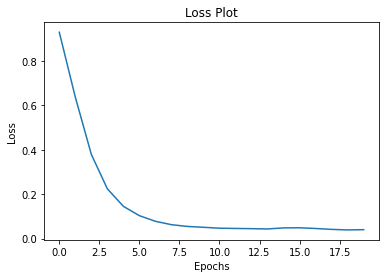

In [ ]:
# Loss plot
import matplotlib.pyplot as plt
plt.plot([x[0] for x in loss_values], [x[1] for x in loss_values])
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Evaluation + Prediction

In [ ]:
SOS_TOKEN = '<start>'
EOS_TOKEN = '<end>'
PAD_TOKEN = '<pad>'
# OOV_TOKEN = '<oov>'
# DUMMY_TOKENS = [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN, OOV_TOKEN]
DUMMY_TOKENS = [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN]

def convert_to_sentence(int_seq, word_index):
    """ convert tensor of integers to human readable sentence

    >>> li = LanguageIndex(['I like ice cream .'])
    >>> convert_to_sentence(IntTensor([5,8,7,6,0]), li)
    'I like ice cream .'

    """
    token_seq = [word_index[int(tok.item())] for tok in int_seq]
    token_seq = [tok for tok in token_seq if tok not in DUMMY_TOKENS]
    # print(' '.join(token_seq))
    return ' '.join(token_seq)

def convert_to_sentences(batch, word_index):
    """ convert a batch of tensor integers to human readable sentences

    >>> lis = LanguageIndex(['Have a nice day !', 'I like playing tennis .'])
    >>> convert_to_sentences([IntTensor([6,8,9,0]), IntTensor([7,10,12,13,1])], lis)
    ['Have a day !', 'I like playing tennis .']

    """
    sentences = []
    for int_seq in batch:
        sentences.append(convert_to_sentence(int_seq, word_index=word_index))
    return sentences

In [ ]:
# Evaluation and Rouge n score calculation

from torch.autograd import Variable
from torch import FloatTensor, IntTensor, LongTensor
import nltk
from nltk.util import ngrams
from scipy import spatial
import os
import spacy
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def predict_batch(dataset, num_batches, source_word_index, target_word_index):
    print(dataset, num_batches, source_word_index, target_word_index)
    """ Calculates total (average) loss and returns translated sentences, correct translations (truth) etc """
    target_sentences = []
    translated_sentences = []
    input_sentences = []
    total_loss = 0
    batch_loss = 0
    for (batch_num, (inp, targ, inp_len)) in enumerate(dataset):
        print(f'Batch num: {batch_num}')
        # if batch_num >= num_batches:
        #     break
        # print(batch)
        loss = 0

        xs, ys, lens = sort_batch(inp, targ, inp_len)
        enc_output, enc_hidden = encoder(xs.to(device), lens, device)
        dec_hidden = enc_hidden

        final_sentences = Variable(torch.zeros(ys.size()))

        # original: ( use teacher forcing - feeding the target as the next input (via dec_input))
        dec_input = torch.tensor([[targ_lang.word2idx['<start>']]] * BATCH_SIZE)
        final_sentences[:, 0] = LongTensor([targ_lang.word2idx['<start>']] * BATCH_SIZE)

        # run code below for every timestep in the ys for this batch
        for t in range(1, ys.size(1)):
            predictions, dec_hidden, _ = decoder(dec_input.to(device),
                                                 dec_hidden.to(device),
                                                 enc_output.to(device))
            loss += loss_function(ys[:, t].to(device), predictions.to(device))
            predictions = predictions.squeeze(0)
            
            final_sentences[:, t] = predictions.argmax(axis=1)

            dec_input = ys[:, t].unsqueeze(1)

        target_sentences.extend(convert_to_sentences(
            ys, word_index=targ_lang.idx2word))
        translated_sentences.extend(convert_to_sentences(
            final_sentences, word_index=targ_lang.idx2word))
        input_sentences.extend(convert_to_sentences(
            xs.numpy().T, word_index=inp_lang.idx2word))
        
        # print(target_sentences)
        # print(translated_sentences)
        # print(input_sentences)

        batch_loss = (loss / int(ys.size(1)))
        total_loss += batch_loss
        # print(batch_loss)
        
        # if batch_num == 2:
        #     break

    total_loss = total_loss / num_batches
    return dict(
        batch_loss=batch_loss,
        total_loss=total_loss,
        input_sentences=input_sentences,
        target_sentences=target_sentences,
        predicted_sentences=translated_sentences)


def print_results(label='', num_batches=10, results=None):
    source_lang_name = 'Sentence'
    target_lang_name = 'Question'
    print()
    print('=' * 40)
    if results is None:
        results = predict_batch(num_batches=num_batches)
    print('==== Translations of Training Set Examples ====')
    triplets = list(zip(results['input_sentences'],
                        results['predicted_sentences'], results['target_sentences']))
    for triplet in triplets:
        print(f'Input ({source_lang_name}) -->\t' + triplet[0])
        print()
        print(f'Truth ({source_lang_name}) -->\t' + triplet[2])
        print(f'Prediction ({source_lang_name}) -->\t' + triplet[1])
        print()
    print(results)
    valLoss = results["total_loss"]
    print(
        f'==== (total_loss: {results["total_loss"]} ====')
    print('=' * 40)
    print()
    return pd.DataFrame(triplets, columns=[
        f'{source_lang_name}',
        f'predicted_{target_lang_name}',
        f'truth_{target_lang_name}']), valLoss
    
def average_rouge_n(pairs):
    """ Compute the average rouge_n score for a sequence of 2-tuples of nautral language strings """
    pairs = list(pairs)
    ave = 0
    n = len(pairs)
    for pair in pairs:
        ave += rouge_n(*pair) / n
    return ave

LANGS = ['en_core_web_sm', 'en_core_web_md', 'en_core_web_lg']
LANGS_ABBREV = 'en enmd enlg'.split()
LANGS += 'de_core_news_sm de_core_news_md de_trf_bertbasecased_lg'.split()
LANGS_ABBREV += 'de demd delg'.split()
LANGS_ABBREV = dict(zip(LANGS_ABBREV, LANGS))
LANG = os.environ.get('SPACY_LANG', LANGS[0])

PUNCTUATION = '\\"\'!()-[]{};:,<>./?@#$%^&*_~ '

nlp = None

# from nmt.utils.spacy_language_model import nlp
# from nmt.utils.spacy_language_model import load as spacy_load
# from nmt.utils.spacy_language_model import tokenize as spacy_tokenize

def add_hunspell_pipe(model):
    try:
        spacy.tokens.Token.get_extension('hunspell_spell')
        # log.debug(f'SpaCy Token already has a hunspell Pipe section . . .')
        return model
    except ValueError:
        pass

def load(lang=None):
    """ Load the specified language model or the small English model, if none specified

    >>> load()  # doctest: +ELLIPSIS
    <spacy.lang.en.English object at ...
    """
    global nlp, UNKNOWN_WORDVEC
    model = None
    # log.info(f"Loading SpaCy model...")
    nlp_lang = getattr(nlp, 'lang', '')
    nlp_meta = getattr(nlp, 'meta', {})
    nlp_size = nlp_meta.get('name', '')[-2:]
    if nlp_lang and (not lang or (nlp_lang == lang[:2] and nlp_size == lang[-2:])):
        model = nlp
    if model is None and lang:
        try:
            model = spacy.load(lang)
        except OSError:
            spacy.cli.download(lang)
            model = spacy.load(lang)
    if model is None:
        if not lang:
            for lang in LANGS:
                try:
                    model = spacy.load(lang)
                    break
                except OSError:
                    pass
        else:
            if model is None:
                lang = LANG
                spacy.cli.download(lang)
                model = spacy.load(lang)
    if 'performance' in model.meta:
        model.meta['accuracy'] = model.meta['performance']

    model = add_hunspell_pipe(model)
    if nlp is None:
        nlp = model
    # load the highest accuracy model into the global singleton nlp variable (user can still override)
    if nlp.lang == 'en':
        if nlp.meta['accuracy']['token_acc'] < model.meta['accuracy']['token_acc']:
            nlp = model
    UNKNOWN_WORDVEC = np.random.randn(nlp._meta['vectors']['width'])
    UNKNOWN_WORDVEC /= np.linalg.norm(UNKNOWN_WORDVEC)
    return model  # return value may be lower accuracy, so `nlp=load('en_web_core_sm')` will have lower accuracy `nlp`


nlp = load(LANG)

def token_generator(text, ignore=None):
    """ Use spacy language model to generate sequence tokens (`str`s)

    >>> '|'.join(token_generator(text="What if you succeed?"))
    'What|if|you|succeed|?'
    """
    ignore = set() if ignore is None else set(ignore)
    return (tok.text for tok in nlp(text) if tok.text not in ignore)


def tokenize(text, ignore=None):
    """ Use spacy language model to list sequence of tokens (word `str`s)

    >>> '|'.join(tokenize(text="What if you succeed?"))
    'What|if|you|succeed|?'
    """
    return list(token_generator(text, ignore=ignore))



def overlapping_words(tokens, reference_tokens):
    """ Count number of words in tokens that are in the reference_tokens sequence

    # "advance" occurs 2 times in reference, "to" occurs 1 time, "we" occurs 1 time
    # 2 + 1 + 1 => 4
    >>> overlapping_words(
    ...     spacy_tokenize("We're going to advance!".lower()),
    ...     spacy_tokenize("Advance! We'll stop at nothing to advance!".lower()))
    4
    >>> overlapping_words(
    ...     "life is stronger than metal and stone , more powerful than typhoons and volcanoes".split(),
    ...     "life is stronger than metal stones , more volcano and typhoon than powerful".split())
    10
    """
    tokens_counter = Counter()
    reference_tokens_counter = Counter()

    tokens_counter.update(tokens)
    reference_tokens_counter.update(reference_tokens)

    count = 0
    for token in reference_tokens_counter.keys():
        reference_count = reference_tokens_counter.get(token, 0)
        sent_count = tokens_counter.get(token, 0)

        if sent_count >= reference_count:
            count += reference_count
        else:
            count += sent_count

    return count


def rouge_n(text, reference_text, tokenizer=tokenize, ignore=PUNCTUATION, stemmer=True, ngram=1):
    """Compute the ROUGE similarity between a text string and a reference text with unigram.

    Specify number of grams in `ngram` argument
    All versions of rouge use case folding (case insensitive)
    Some ignore sentence-ending punctuation (?, ., !)
    Some use stemming.
    Some ignore stop words.

    References:
      https://www.aclweb.org/anthology/U19-1008.pdf (some example scores for variants)
      https://stats.stackexchange.com/a/312354/15974

    >>> life = "life is stronger than metal and stones, more powerful than typhoons and volcanoes"
    >>> life_shuffled_lemmas = "life is stronger than metal and stone,  more powerful than typhoon  and volcano"
    >>> rouge_n(
    ...     life,
    ...     life_shuffled_lemmas)
    1.0
    >>> rouge_n(
    ...     text=life_shuffled_lemmas,
    ...     reference_text=life)
    1.0

    >>> rouge_n('', '')
    0.0

    >>> rouge_n("Clean rooms", "The rooms were clean and neat.", )
    0.5



    >>> rouge_n("typhoons and volcanoes", "typhoon  and volcano")
    1.0
    >>> rouge_n("typhoons and volcanoes", "typhoon  and volcano", stemmer=False)
    0.3333...

    >>> rouge_n('?', '?')
    0.0
    """
    stemmer = nltk.stem.PorterStemmer() if stemmer is True else stemmer
    stemmer = getattr(stemmer, 'stem', stemmer)
    if not stemmer or not callable(stemmer):
        def stemmer(s):
            return s
    ignore = set() if ignore is None or ignore is False else set(str(i) for i in ignore)

    tokens = [stemmer(t) for t in tokenizer(text, ignore=ignore)]
    reference_tokens = [stemmer(t) for t in tokenizer(reference_text, ignore=ignore)]

    # Convert into list of ngrams
    tokens = list(ngrams(tokens, ngram))
    reference_tokens = list(ngrams(reference_tokens, ngram))
    count = overlapping_words(tokens, reference_tokens)

    try:
        if len(tokens) == 0 or len(reference_tokens) == 0:
            warnings.warn(
                "Number of tokens for either input and reference are zero",
                RuntimeWarning,
                stacklevel=2)

        recall = count / len(reference_tokens)
    except ZeroDivisionError:
        recall = 0.0
    try:
        precision = count / len(tokens)
    except ZeroDivisionError:
        precision = 0.0
    try:
        return 2 * ((precision * recall) / (precision + recall))
    except ZeroDivisionError:
        return 0.0

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
valuesSentence = ['The sky is blue', 
                  'Barack Hussein Obama II is an American politician and attorney who served as the 44th president of the United States from 2009 to 2017.', 
                  'Tom denied having the money.', 
                  'Application process is quite simple', 
                  'Canada is a country in North America and its ten provinces and three territories extend from the Atlantic to the Pacific and northward into the Arctic Ocean', 
                  'The sky is blue', 
                  'Barack Hussein Obama II is an American politician and attorney who served as the 44th president of the United States from 2009 to 2017.', 
                  'Tom denied having the money.', 
                  'Application process is quite simple', 
                  'Canada is a country in North America and its ten provinces and three territories extend from the Atlantic to the Pacific and northward into the Arctic Ocean', 
                  'The sky is blue', 
                  'Barack Hussein Obama II is an American politician and attorney who served as the 44th president of the United States from 2009 to 2017.', 
                  'Tom denied having the money.', 
                  'Application process is quite simple', 
                  'Canada is a country in North America and its ten provinces and three territories extend from the Atlantic to the Pacific and northward into the Arctic Ocean', 
                  'The sky is blue', 
                  'Barack Hussein Obama II is an American politician and attorney who served as the 44th president of the United States from 2009 to 2017.', 
                  'Tom denied having the money.', 
                  'Application process is quite simple', 
                  'Canada is a country in North America and its ten provinces and three territories extend from the Atlantic to the Pacific and northward into the Arctic Ocean', 
                  'The sky is blue', 
                  'Barack Hussein Obama II is an American politician and attorney who served as the 44th president of the United States from 2009 to 2017.', 
                  'Tom denied having the money.', 
                  'Application process is quite simple', 
                  'Canada is a country in North America and its ten provinces and three territories extend from the Atlantic to the Pacific and northward into the Arctic Ocean', 
                  'The sky is blue', 
                  'Barack Hussein Obama II is an American politician and attorney who served as the 44th president of the United States from 2009 to 2017.', 
                  'Tom denied having the money.', 
                  'Application process is quite simple', 
                  'Canada is a country in North America and its ten provinces and three territories extend from the Atlantic to the Pacific and northward into the Arctic Ocean', 
                  'The sky is blue', 
                  'Barack Hussein Obama II is an American politician and attorney who served as the 44th president of the United States from 2009 to 2017.', 
                  'Tom denied having the money.', 
                  'Application process is quite simple', 
                  'Canada is a country in North America and its ten provinces and three territories extend from the Atlantic to the Pacific and northward into the Arctic Ocean', 
                  'The sky is blue', 
                  'Barack Hussein Obama II is an American politician and attorney who served as the 44th president of the United States from 2009 to 2017.', 
                  'Tom denied having the money.', 
                  'Application process is quite simple', 
                  'Canada is a country in North America and its ten provinces and three territories extend from the Atlantic to the Pacific and northward into the Arctic Ocean', 
                  'The sky is blue', 
                  'Barack Hussein Obama II is an American politician and attorney who served as the 44th president of the United States from 2009 to 2017.', 
                  'Tom denied having the money.', 
                  'Application process is quite simple', 
                  'Canada is a country in North America and its ten provinces and three territories extend from the Atlantic to the Pacific and northward into the Arctic Ocean']
valuesQuestion = ['What color is the sky?', 
                  'Who is Barack Hussein Obama II?', 
                  'Did Tom have the money?', 
                  'How is the application process?', 
                  'What is Canada?', 
                  'What color is the sky?', 
                  'Who is Barack Hussein Obama II?', 
                  'Did Tom have the money?', 
                  'How is the application process?', 
                  'What is Canada?', 
                  'What color is the sky?', 
                  'Who is Barack Hussein Obama II?', 
                  'Did Tom have the money?', 
                  'How is the application process?', 
                  'What is Canada?', 
                  'What color is the sky?', 
                  'Who is Barack Hussein Obama II?', 
                  'Did Tom have the money?', 
                  'How is the application process?', 
                  'What is Canada?', 
                  'What color is the sky?', 
                  'Who is Barack Hussein Obama II?', 
                  'Did Tom have the money?', 
                  'How is the application process?', 
                  'What is Canada?', 
                  'What color is the sky?', 
                  'Who is Barack Hussein Obama II?', 
                  'Did Tom have the money?', 
                  'How is the application process?', 
                  'What is Canada?', 
                  'What color is the sky?', 
                  'Who is Barack Hussein Obama II?', 
                  'Did Tom have the money?', 
                  'How is the application process?', 
                  'What is Canada?', 
                  'What color is the sky?', 
                  'Who is Barack Hussein Obama II?', 
                  'Did Tom have the money?', 
                  'How is the application process?', 
                  'What is Canada?', 
                  'What color is the sky?', 
                  'Who is Barack Hussein Obama II?', 
                  'Did Tom have the money?', 
                  'How is the application process?', 
                  'What is Canada?']

# result = [valuesSentence, valuesQuestion]
# from pandas import DataFrame

# df = DataFrame (result).transpose()
# df.columns = ['Sentence','Question']
# print(df)

df = pd.read_csv('/gdrive/My Drive/Jobs + Startup/Tangible AI/Question Generation - Tangible AI/Datasets/CustomData.csv')
# print(df)

df["Sentence"] = df.Sentence.apply(lambda w: preprocessSentence(w))
df["Question"] = df.Question.apply(lambda w: preprocessSentence(w))

# print(df)

for es in df["Sentence"].values.tolist():
     for s in es.split(' '): 
        if s not in inp_lang.word2idx: 
            print('FALSE', s)

# valBool = [[inp_lang.word2idx[s] for s in es.split(' ')]  for es in df["Sentence"].values.tolist()]

input_tensor2 = [[inp_lang.word2idx[s] for s in es.split(' ')]  for es in df["Sentence"].values.tolist()]
target_tensor2 = [[targ_lang.word2idx[s] for s in eng.split(' ')]  for eng in df["Question"].values.tolist()]

input_tensor2 = [padSequences(x, max_length_inp) for x in input_tensor2]
target_tensor2 = [padSequences(x, max_length_tar) for x in target_tensor2]

In [ ]:
# train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val[:200], target_tensor_val[:200])

# dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
#                      drop_last=True,
#                      shuffle=True)

dataset_val = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [ ]:
len(inp_lang.word2idx)
print(inp_lang.word2idx)

{'<pad>': 0, '!': 1, ',': 2, '.': 3, '<end>': 4, '<start>': 5, '?': 6, 'a': 7, 'aa': 8, 'aaa': 9, 'aac': 10, 'aacsb': 11, 'aan': 12, 'aapka': 13, 'aarohan': 14, 'aaron': 15, 'ab': 16, 'ababa': 17, 'abacha': 18, 'abacus': 19, 'abad': 20, 'abagnale': 21, 'abalone': 22, 'abandon': 23, 'abandoned': 24, 'abandoning': 25, 'abandonment': 26, 'abarot': 27, 'abatement': 28, 'abaza': 29, 'abbas': 30, 'abbasid': 31, 'abbasids': 32, 'abbey': 33, 'abbeys': 34, 'abbie': 35, 'abbot': 36, 'abbots': 37, 'abbott': 38, 'abbreviated': 39, 'abbreviation': 40, 'abc': 41, 'abcd': 42, 'abd': 43, 'abda': 44, 'abdacom': 45, 'abdel': 46, 'abdi': 47, 'abdicate': 48, 'abdication': 49, 'abdirashid': 50, 'abdisalam': 51, 'abdomen': 52, 'abdominal': 53, 'abduction': 54, 'abdul': 55, 'abdulhamid': 56, 'abdullah': 57, 'abdulle': 58, 'abdulmecid': 59, 'abdulrahman': 60, 'abdus': 61, 'abe': 62, 'abel': 63, 'abelian': 64, 'abercrombie': 65, 'aberdeen': 66, 'aberhart': 67, 'abetting': 68, 'abhaya': 69, 'abhidhamma': 70, 'a

In [ ]:
# val_loss = None
train_results = predict_batch(dataset=dataset_val, source_word_index=inp_lang, target_word_index=targ_lang, num_batches=BATCH_SIZE)
triplets, valLoss = print_results(label='train', results=train_results)

<torch.utils.data.dataloader.DataLoader object at 0x7f7e45157890> 64 <__main__.languageIndex object at 0x7f7f42b16850> <__main__.languageIndex object at 0x7f7f42b167d0>
Batch num: 0
Batch num: 1
Batch num: 2

==== Translations of Training Set Examples ====
Input (Sentence) -->	furthermore , since the advent of the convention on the rights of the child in children here defined as under , almost every country in the world except the u . s . and south sudan has legally committed to advancing an anti discriminatory stance towards young people of all ages .

Truth (Sentence) -->	what two countries have not legally committed to advancing an anti discriminaory stance towards young people ?
Prediction (Sentence) -->	what two countries have not legally committed to advancing an anti discriminaory stance towards young people ?

Input (Sentence) -->	another text influenced by enlightenment values was charles burney s a general history of music from the earliest ages to the present period , which 

In [ ]:
# val_loss = None
train_results = predict_batch(dataset=dataset_val, source_word_index=inp_lang, target_word_index=targ_lang, num_batches=BATCH_SIZE)
triplets, valLoss = print_results(label='train', results=train_results)

<torch.utils.data.dataloader.DataLoader object at 0x7fef7a82d610> 64 <__main__.languageIndex object at 0x7ff09191d610> <__main__.languageIndex object at 0x7ff0fb1ff510>
Batch num: 0

==== Translations of Training Set Examples ====
Input (Sentence) -->	a film , also called a movie , motion picture or moving picture , is a work of visual art used to show experiences that communicate ideas , stories , perceptions , feelings , beauty , or atmosphere through the use of moving images .

Truth (Sentence) -->	how many people lived in the affected area ?
Prediction (Sentence) -->	what long lichen saw in the use by on

Input (Sentence) -->	canada is a country in north america and its ten provinces and three territories extend from the atlantic to the pacific and northward into the arctic ocean

Truth (Sentence) -->	what is canada ?
Prediction (Sentence) -->	in time the going

Input (Sentence) -->	the ultimate objective of natural language processing is to read , understand , and make sense of th

In [ ]:
triplets.head()
# print(triplets[''])
print("Rouge score", rouge_n(triplets['predicted_Question'][0], triplets['truth_Question'][0]))

finalRouge_n_score = average_rouge_n(zip(triplets['predicted_Question'], triplets['truth_Question']))
print()
print(finalRouge_n_score)

Rouge score 0.23529411764705882

0.18190256522032688


In [ ]:
# Print summary
print(f'Batch Size: {BATCH_SIZE}')
print(f'Embedding Size: {embedding_dim}')
print(f'Units: {units}')
print()
print(f'Final Epoch: {finalEpoch}')
print(f'Training Loss: {finalEpochLoss}')
print(f'Testing Loss: {valLoss}')
print(f'Rouge Score: {finalRouge_n_score}')

Batch Size: 64
Embedding Size: 256
Units: 2048



NameError: ignored

In [ ]:
torch.save(encoder.state_dict(), '/gdrive/My Drive/Jobs + Startup/Tangible AI/Question Generation - Tangible AI/nmt Models/encoder1.dict')
torch.save(decoder.state_dict(), '/gdrive/My Drive/Jobs + Startup/Tangible AI/Question Generation - Tangible AI/nmt Models/decoder1.dict')

In [ ]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## TODO: Combine the encoder and decoder into one class
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, units, BATCH_SIZE)

encoder.load_state_dict(torch.load('/gdrive/My Drive/Jobs + Startup/Tangible AI/Question Generation - Tangible AI/nmt Models/encoder1.dict'))
decoder.load_state_dict(torch.load('/gdrive/My Drive/Jobs + Startup/Tangible AI/Question Generation - Tangible AI/nmt Models/decoder1.dict'))

encoder.to(device)
decoder.to(device)

Decoder(
  (embedding): Embedding(18025, 256)
  (gru): GRU(2304, 2048, batch_first=True)
  (fc): Linear(in_features=2048, out_features=18025, bias=True)
  (W1): Linear(in_features=2048, out_features=2048, bias=True)
  (W2): Linear(in_features=2048, out_features=2048, bias=True)
  (V): Linear(in_features=2048, out_features=1, bias=True)
)